# Prophet

[**Prophet**](https://facebook.github.io/prophet/) is a forecasting algorithm developed at Facebook and targeting "business time series" - time series derived from human activity, typically having seasonality and trend on human time scales like days, weeks, years. Features of the Prophet algorithm are:

- model is based on overall trend, seasonality, and holidays
- "analyst in the loop": ability to incorporate domain knowledge to tune parameters of the model

## Preamble

In [1]:
import pandas
import seaborn
import matplotlib
import numpy

In [2]:
import forecast_lab

In [3]:
seaborn.set_style("ticks")
matplotlib.pyplot.rcParams["axes.grid"] = True
matplotlib.pyplot.rcParams["figure.figsize"] = (20, 3)

## Example: Forecasting Taxi Trips

In [4]:
import fbprophet

In [5]:
taxi_trips = forecast_lab.datasets.read_chicago_taxi_trips_daily()

In [6]:
taxi_trips.head()

,Trips
Date,
2013-01-01,96
2013-01-02,53
2013-01-03,61
2013-01-04,79
2013-01-05,76


Prophet expects the input time series in the format of a `pandas.DataFrame` with columns `ds` for time and `y` for values.

In [7]:
taxi_trips_p  = pandas.DataFrame(taxi_trips).reset_index()
taxi_trips_p.columns = ["ds", "y"]

In [8]:
taxi_trips_p.head()

,ds,y
0,2013-01-01,96
1,2013-01-02,53
2,2013-01-03,61
3,2013-01-04,79
4,2013-01-05,76


In [9]:
taxi_trips_p["ds"].max()

Timestamp('2017-05-31 00:00:00')

Now the model can be fitted to the time series:

In [10]:
%time prophet_model = fbprophet.Prophet().fit(taxi_trips_p)

/Users/cls/anaconda3/lib/python3.7/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CPU times: user 822 ms, sys: 24.7 ms, total: 846 ms
Wall time: 1.01 s


In order to produce a forecast, one needs to call the model's helper method `make_future_dataframe` with the parameters of the desired forecast:

In [11]:
fd = prophet_model.make_future_dataframe(periods=10, freq="D")
fd[fd["ds"] > "2017-05-31"]

,ds
1612,2017-06-01
1613,2017-06-02
1614,2017-06-03
1615,2017-06-04
1616,2017-06-05
1617,2017-06-06
1618,2017-06-07
1619,2017-06-08
1620,2017-06-09
1621,2017-06-10


In [12]:
ts_forecast = prophet_model.predict(
    prophet_model.make_future_dataframe(periods=100, freq="D")
)

The forecast result is a dataframe with values for the historical time series plus the future timeframe:

In [13]:
ts_forecast[ts_forecast["ds"] > taxi_trips.index.max()]["yhat"].shape

(100,)

In [14]:
ts_forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1707,2017-09-04,43.349824,1.410346,43.265480,42.590493,44.194843,-22.176015,-22.176015,-22.176015,-15.542574,-15.542574,-15.542574,-6.633442,-6.633442,-6.633442,0.0,0.0,0.0,21.173808
1708,2017-09-05,43.248528,6.069683,48.852489,42.477288,44.108460,-15.411157,-15.411157,-15.411157,-8.925695,-8.925695,-8.925695,-6.485462,-6.485462,-6.485462,0.0,0.0,0.0,27.837371
1709,2017-09-06,43.147232,13.336331,54.973552,42.368060,44.022483,-9.332449,-9.332449,-9.332449,-3.063450,-3.063450,-3.063450,-6.268999,-6.268999,-6.268999,0.0,0.0,0.0,33.814783
1710,2017-09-07,43.045936,21.319653,63.604055,42.262003,43.937085,-0.668199,-0.668199,-0.668199,5.315867,5.315867,5.315867,-5.984066,-5.984066,-5.984066,0.0,0.0,0.0,42.377737
1711,2017-09-08,42.944640,35.675708,78.418626,42.155946,43.851824,13.977125,13.977125,13.977125,19.609311,19.609311,19.609311,-5.632185,-5.632185,-5.632185,0.0,0.0,0.0,56.921765


/Users/cls/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


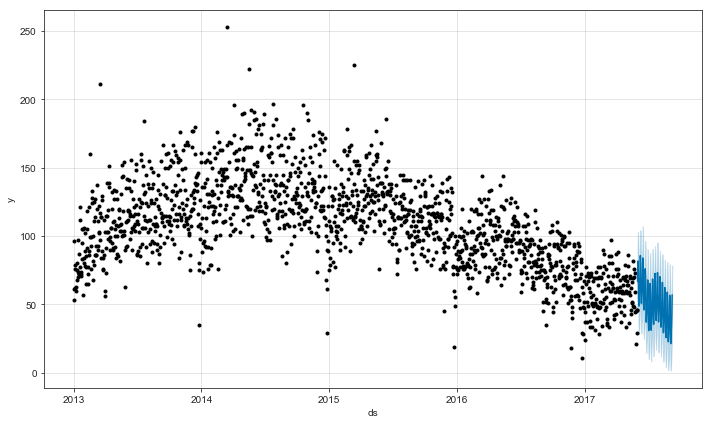

In [15]:
prophet_model.plot(ts_forecast[ts_forecast["ds"] > taxi_trips.index.max()], );

We can get some insights into the model by plotting its components - an overall trend as well as seasonal components:

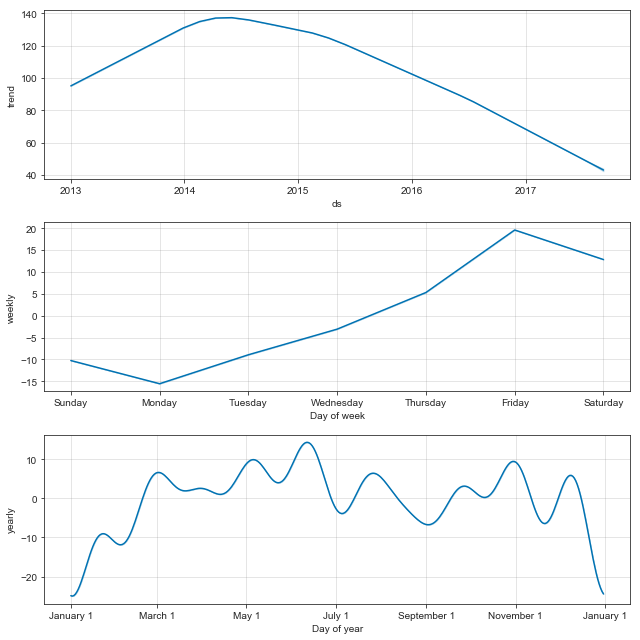

In [16]:
prophet_model.plot_components(ts_forecast);


We provide a wrapper class to use a Prophet model in the `ForecastEvaluation`:

In [17]:
forecast_lab.ProphetWrapper??

Init signature: forecast_lab.ProphetWrapper(estimator_params={}, fit_params={})
Source:        
class ProphetWrapper(ForecastWrapper):
    """
    Wrapper for the fbprophet forecasting.
    """

    def __init__(
        self,
        estimator_params={},
        fit_params={},
    ):
        super(ProphetWrapper, self).__init__(
            fbprophet.Prophet,
            estimator_params,
            fit_params
        )

    def fit(
        self,
        ts: pandas.Series,
        ext_vars: pandas.DataFrame = None,
    ):
        """
        Fit the model to a time series
        """
        if ext_vars is not None:
            raise ValueError("TODO: pass external variables to Prophet")
        if not hasattr(ts, "freq"):
            raise ValueError("The time series frequency attribute `freq` must be set")
        self.freq = ts.freq
        # Prophet time series format
        ts_prophet = pandas.DataFrame(ts).reset_index()
        ts_prophet.columns = ["ds", "y"]
        self.mo

## Evaluation

/Users/cls/anaconda3/lib/python3.7/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


======== iteration 0 ==========


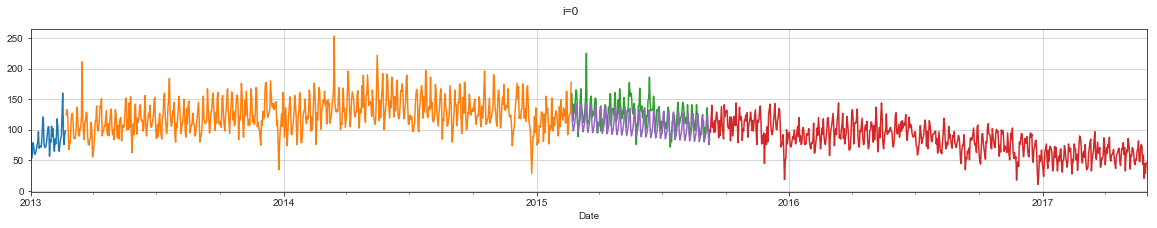

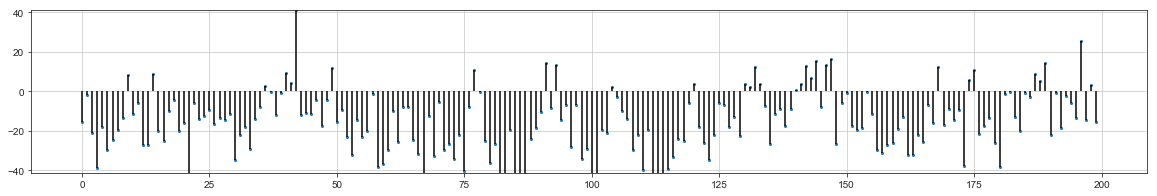

/Users/cls/anaconda3/lib/python3.7/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


======== iteration 1 ==========


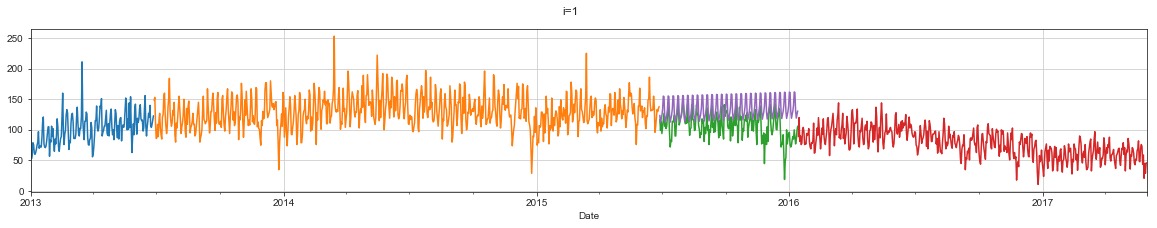

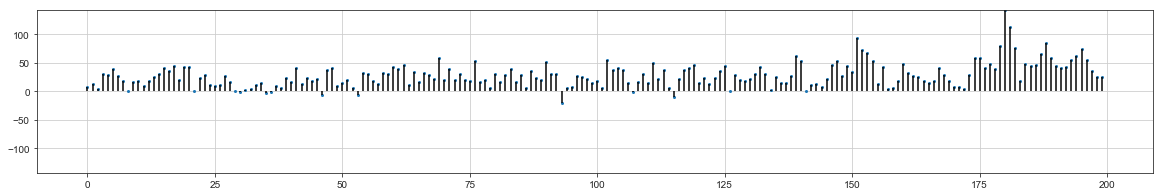

/Users/cls/anaconda3/lib/python3.7/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


======== iteration 2 ==========


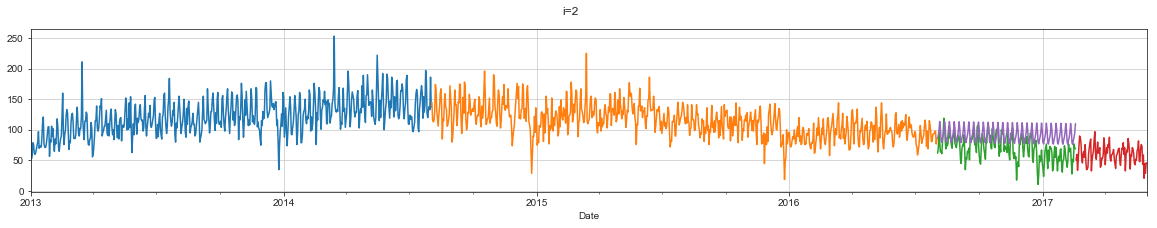

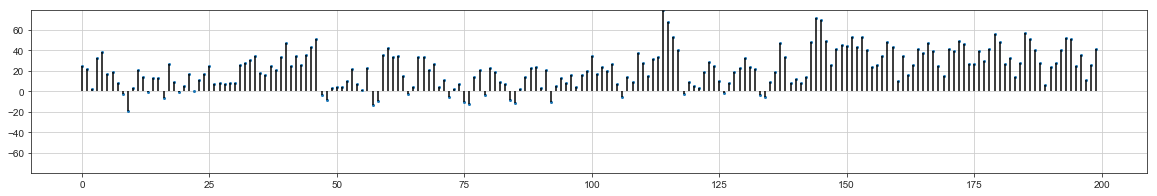

MAPE    31.446660
RSME    28.788124
dtype: float64

In [18]:
forecast_lab.ForecastEvaluation(
        ts=taxi_trips["Trips"],
        forecasting=forecast_lab.ProphetWrapper(),
        test_window_size=200,
        train_window_size=730,
        metrics={
            "MAPE": forecast_lab.metrics.mean_absolute_percentage_error,
            "RSME": forecast_lab.metrics.root_mean_squared_error
        }
).evaluate(
    k=3, 
    plot_segments=True,
    plot_residuals=True,
).get_metrics().mean()

## References

- [Paper: Forecasting at scale](https://peerj.com/preprints/3190/)

---
_This notebook is licensed under a [Creative Commons Attribution 4.0 International License (CC BY 4.0)](https://creativecommons.org/licenses/by/4.0/). Copyright © 2019 [Point 8 GmbH](https://point-8.de)_